# TP5 : Mesure de l’absorption de la lumière par des liquides
### Auteur : ARGUELLO Camilo

### Introduction

Dans ce TP, notre objectif est d'estimer les coefficients selon la loi de Beer-Lambert. Pour cela, nous allons utiliser un montage expérimental avec l'application [PhyPhox](https://phyphox.org/), qui nous permettra de mesurer l'intensité lumineuse $I$ en utilisant un liquide sombre (soda de concentration inconnue). Ensuite, nous allons estimer ces coefficients à l'aide de trois méthodes différentes. Finalement, on analisera la méthode qui nous donne les valeur les plus proches aux vraies valeurs.

### Loi de Beer-Lambert

La loi de Beer-Lambert est une loi qui décrit l'absorption de la lumière par un milieu. Elle est donnée par l'équation suivante:

$$I = I_0 \; e^{-\epsilon \ l \ C} = I_0 \; e^{-\mu \ l}$$

Où $I_0$ est l'intensité lumineuse incidente, $I$ est l'intensité lumineuse transmise, $\epsilon$ est le coefficient d'absorption molaire, $l$ est l'épaisseur du milieu, et $C$ est la concentration du milieu.

À l'aide de cette relation, nous allons estimer **le coefficient d'absortion molaire $\epsilon$**, à partir de données expérimentales mesurés avec le capteur de luminosité de notre smartphone, en fonction de longueurs connues de liquide traversées par la lumière. 

#### Détermination de la position du capteur de luminosité


Pour réaliser cette expérience, nous utiliserons l'application Phyphox sur notre smartphone avec sa fonction de mesure de luminosité. En accédant à l'onglet 'Composantes' de l'application, nous positionnerons le capteur sous la source lumineuse. Ce dernier nous fournira alors une mesure de luminosité exprimée en lux.

Afin de vérifier le bon étalonnage du capteur, on place notre doigt sous le capteur, et on vérifie que l'intensité lumineuse mesurée est égale à 0. $l_x = 0$.

**Remarque**: Qu'est c'est passe si lorsqu'on place notre doigt sur le capteur, il ne marque pas 0?

> Dans ce cas on doit faire prendre cette valeur comme une incertitude sur la mesure de luminosité.

### Montage et protocole expérimental

Le montage expérimental est composé d'une source de lumière (lampe), d'un liquide (soda), et d'un capteur qui mesure l'intensité lumineuse (téléphone). La source de lumière est une LED blanche qui émet de la lumière dans le visible. Le liquide est contenu dans un bécher. Ainsi qu'un mètre pour mesurer les hauteurs du liquide Le montage est illustré dans la figure ci-dessous.

![Mesure Illustration](https://camiloarguello.xyz/img/mesure-illustration1.jpg)

1. L'expériment doit se faire dans un endroît sombre, pour éviter que la lumière ambiante interfère avec les mesures.
   
2. On place le bécher sur le capteur (téléphone), et en-dessous de la source de lumière. Eux, ils doivent être alignés, pour que la lumière passe à travers le liquide et arrive au capteur.

3. On demarre la collecte des données de luminosité avec l'application Phyphox. Ensuite, on mesure différentes longueurs de liquide dans le bécher, en prenant soin de ne pas déplacer le bécher ni renverser de liquide sur le smartphone. On va s'aider de la fonctionnalité de contrôle à distance.

4. On répéte les mesures pour différentes longueurs de liquide, toujours en prenant les mêmes précautions.

D’après le protocole expérimental, on mesure la hauteur de la solution liquide à l’aide d’un mètre.

On estime donc l’erreur sur la lecture de la hauteur à $\Delta h \approx  \pm 0.1 \ cm$.

Pour estimer une erreur sur la luminosité, on place un objet sombre devant la lampe pour bloquer la lumière, puis on le déplace. Cette opération est répétée plusieurs fois, en tenant compte notamment de la position du bécher au-dessus du téléphone. On constate que lorsque l'on place un objet sombre devant la lampe, l'intensité lumineuse diminue.

Le niveau d’erreur sur la luminosité que nous retiendrons par la suite est de $\Delta l \approx \pm 16.4 \ Lx$.

![Niveux de liquide avec des erreurs](https://camiloarguello.xyz/img/glass-levels.jpg)

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import qexpy
from qexpy import MeasurementArray
import qexpy.plotting as qplt
from scipy.stats import linregress
from scipy.optimize import minimize
from IPython.display import display, Math

In [28]:
def load_data(folder_path, color='blue'):
    """
    Cette fonction charge les données des fichiers csv dans un dictionnaire
    @param folder_path: chemin du dossier contenant les données
    @param color: couleur de liquide (on a testé avec 3 couleurs différents bleu, rouge, jaune) des données à charger 
    """
    Color={}
    for folder_name in os.listdir(folder_path):
        folder_path_full = os.path.join(folder_path, folder_name)
        if os.path.isdir(folder_path_full):
            raw_data_path = os.path.join(folder_path_full, 'Raw Data.csv')
            if os.path.isfile(raw_data_path):
                var_name = extract_number(folder_name, color)
                Color[var_name] = pd.read_csv(raw_data_path)
    return Color

def extract_number(folder_name, color='yellow'):
    """
    Cette fonction extrait le nom de color avec son numéro pour nommer la colonne
    @param folder_name: nom du dossier
    @param color: couleur à extraire
    """
    substrings = folder_name.split(color)
    if len(substrings) > 1:
        color_number = substrings[1]
        return f'{color}{color_number}'
    else:
        return None

On réalise une série de **6 mesures** correspondant à **6 hauteurs** de liquide différentes. On va stocker les données dans un `dict` sous la forme suivante:

```python
data = {
    'blue10': [...['Temps (s)'], ...['Illuminance (lx)']], # mesures pour la hauteur de 1 cm
    'blue20': [...], # mesures pour la hauteur de 2 cm
    'blue30': [...], # mesures pour la hauteur de 3 cm
    'blue40': [...], # mesures pour la hauteur de 4 cm
    'blue50': [...], # mesures pour la hauteur de 5 cm
    'blue60': [...]  # mesures pour la hauteur de 6 cm
}
```

In [29]:
folder_path = './data/Blue/'
Data = load_data(folder_path, color='blue')

heights = np.array([1.05, 2.03, 3.08, 4.03, 5.07, 6.05]) # Hauteur des liquides mésurés en cm
height_uncertainty = 0.1 * np.ones(len(heights)) # Incertitude sur la hauteur des liquides

Vu que l'application Phyphox nous donne un tableau au cours du temps pour chaque mesure, et qu'on a bien vérifié que nos mésures son bien estables, alors on prendra la moyenne des valeurs pour chaque hauteur.

In [30]:
luminosites = np.array([Data[key]['Illuminance (lx)'].mean() for key in sorted(Data.keys())])
luminosite_uncertainty = 16.4 * np.ones(len(luminosites)) # Incertitude sur la luminosité

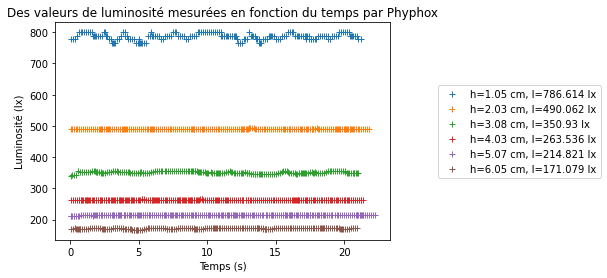

In [31]:
fig, ax = plt.subplots()

for i, height in enumerate(list(sorted(Data.keys())), start=0):
    ax.plot(Data[height]['Time (s)'], Data[height]['Illuminance (lx)'], '+', 
            label=f'h={heights[i]} cm, l={np.round(luminosites[i], 3)} lx')
    
plt.title('Des valeurs de luminosité mesurées en fonction du temps par Phyphox')
plt.xlabel('Temps (s)')
plt.ylabel('Luminosité (lx)')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Erreurs relatives sur les hauteurs: 3.97 %
Erreurs relatives sur les luminosités 5.59 %


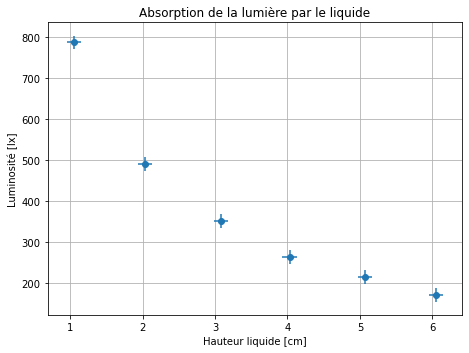

In [32]:
xs = MeasurementArray(heights, height_uncertainty, unit='cm', name='Hauteur liquide ')
ys = MeasurementArray(luminosites, luminosite_uncertainty, unit='lx', name='Luminosité ')

# Erreurs relatives sur les hauteurs et les luminosités
dxs = height_uncertainty / heights
dys = luminosite_uncertainty / luminosites

print('Erreurs relatives sur les hauteurs: {:.2f} %'.format(np.mean(dxs) * 100))
print('Erreurs relatives sur les luminosités {:.2f} %'.format(np.mean(dys) * 100))

qplt.plot(xs, ys)
figure = qplt.get_plot()
figure.title = 'Absorption de la lumière par le liquide'
qplt.show()

D'après le graphique, on peut remarquer qu'on obtient une fonction exponentielle décroissante, ce qui confime l'expression de la loi de Beer-Lambert. De même, l'erreur qui semble être dominante c'est celle portant sur l'intensité lumineuse. En plus on peut confirmer cette affirmation en analysant les erreurs relatives $\frac{\Delta \mu}{\mu} = 5.59\%$, tandis que pour $\frac{\Delta h}{h} = 3.97\%$, où on voit une erreur relative plus importante pour celle de l'intensité par rapport celle sur l'hauteur.

### Adjustement du modèle

Nous allons ajuster les données expérimentales à trois modèles différents:

- Un modèle analytique par minimisation du $\chi^2$.
- Un modèle numérique de minimisation du $\chi^2$ avec `scipy`.
- Un modèle d'ajustement par `qexpy`.

#### Modèle analytique par minimisation du $\chi^2$

On a vu la dependence de la loi de Beer-Lambert en fonction de l'intensité lumineuse. Maintenant notre objectif est de linéariser cette rélation à l'aide du logarithme naturel. 

D'après la loi de Beer-Lambert, on a:

$$ I = I_0 \; e^{-\epsilon \ l \ C} $$

$$ \ln (I) = \ln (I_0) + \ln(e^{\epsilon \ l \ C}) $$

$$ \ln (I) = \ln (I_0) - \epsilon \ l \ C $$

En commençant par la méthode analytique où on peut trouver les valeurs de $a$ et $b$ en résolvant l'équation de la forme: $y = a \ x + b$. Et en identifiant à $\ln(I)= a \ l + b$.

$$ a = - \epsilon \ C \quad \text{et} \quad b = \ln(I_0) $$

On aura:

$$ \epsilon = - \frac{a}{C} \quad \text{et} \quad I_0 = e^b$$

En négligeant les erreurs sur les hauteurs par rapport à celles sur l'intensité, on a:

$$ \Delta \ln(I_i) = \sqrt{\left( \frac{\Delta I_i}{I_i} \right)^2} = \frac{\Delta I_i}{I_i} $$

Nous sommes dans le cas d'un ajustement linéaire, on peut écrire:

$$ A = \sum_i \frac{x_i \ y_i}{\sigma_i^2} = \sum_{n=1}^{6} \frac{h_i \ \ln(I_i)}{\sigma_{\Delta \ln(I_i)}^2} $$

$$ B = \sum_i \frac{x_i^2}{\sigma_i^2} = \sum_{n=1}^{6} \frac{h_i^2}{\sigma_{\Delta \ln(I_i)}^2} $$

$$ C = \sum_i \frac{x_i}{\sigma_i^2} = \sum_{n=1}^{6} \frac{h_i}{\sigma_{\Delta \ln(I_i)}^2} $$

$$ D = \sum_i \frac{y_i}{\sigma_i^2} = \sum_{n=1}^{6} \frac{\ln(I_i)}{\sigma_{\Delta \ln(I_i)}^2} $$

$$ E = \sum_i \frac{1}{\sigma_i^2} = \sum_{n=1}^{6} \frac{1}{\sigma_{\Delta \ln(I_i)}^2} $$

D'où on peut trouver les valeurs de $a$ et $b$:

$$ a = \frac{A \ E - D \ C}{B \ E - C^2} \quad \text{et} \quad b = \frac{D \ B - A \ C}{B \ E - C^2} $$


a = -0.33 cm
b = 6.97


<IPython.core.display.Math object>

<IPython.core.display.Math object>

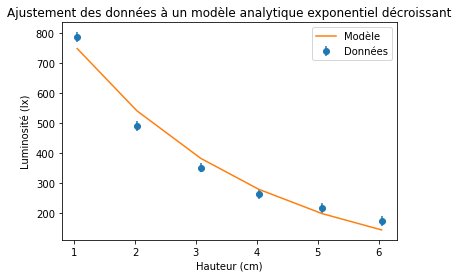

In [33]:
h_i = heights.copy()
I_i = luminosites.copy()
ln_i = np.log(I_i)
sigma_i = dys * ln_i

A = np.sum(h_i * ln_i / sigma_i**2)
B = np.sum(h_i**2 / sigma_i**2)
C = np.sum(h_i / sigma_i**2)
D = np.sum(ln_i / sigma_i**2)
E = np.sum(1 / sigma_i**2)

a = (A * E - D * C) / (B * E - C**2)
b = (D * B - A * C) / (B * E - C**2)

mu = -a
I_0 = np.exp(b)

y_analytique = {
  'I_0': I_0,
  'mu': mu,
}

print('a = {:.2f} cm'.format(a))
print('b = {:.2f}'.format(b))

display(Math(r'I_0 = {:.2f} \, \text{{lx}}'.format(np.exp(b))))
display(Math(r'\mu = {:.2f} \, \text{{cm}}^{{-1}}'.format(mu)))

# Modele
I = I_0 * np.exp(-mu * heights)

plt.errorbar(heights, luminosites, yerr=luminosite_uncertainty, fmt='o', label='Données')
plt.plot(heights, I, label='Modèle')
plt.title('Ajustement des données à un modèle analytique exponentiel décroissant')
plt.xlabel('Hauteur (cm)')
plt.ylabel('Luminosité (lx)')
plt.legend()
plt.show()


L'ajustement par la méthode analytique nous a donné une valeur de $I_0$ égale à $1060.43$ Lx qui est très proche de la valeur mesurée lorsqu'il n'y a pas d'objet entre la source de lumière et le capteur. En plus, on a obtenu une valeur de $\mu = 0.33 \ \text{cm}^{-1}$.

#### Minimisation numérique par minimisation $\chi^2$ avec `scipy`

Maintenant, on s'intéresse à la minimisation de la fonction $\chi^2$ qui va nous permettre de trouver les valeurs de $I_0$ et $\mu$ qui minimisent une fonction de coût donnée.

$$ \chi^2 = \sum_{i=1}^n \left( \frac{y_i - I_0 e^{-\epsilon C x_i}}{\sigma_i} \right)^2 = \sum_{i=1}^n \left( \frac{I_i - I_0 \ e^{-(\mu \ h_i)}}{\sigma_i} \right)^2 $$

avec $x_i$ les hauteurs de liquide, $y_i$ les valeurs de luminosité, et $\sigma_i$ les erreurs sur les valeurs de luminosité.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

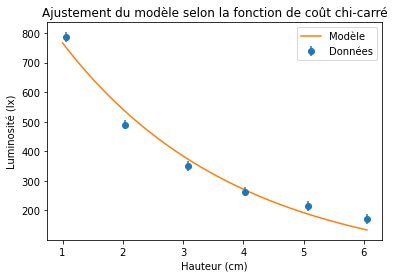

In [34]:
# Fonction du modèle
def f(x, I_O, mu):
  return I_O * np.exp(-mu * x)

# chi-carré
def chi2(params, x, y, dy):
  mu, I_O = params
  return np.sum(((y - f(x, I_O, mu)) / dy)**2)

# Minimisation
params0 = np.array([1, 1000])
result = minimize(chi2, params0, args=(heights, luminosites, luminosite_uncertainty))

mu, I_O = result.x
y_scipy = {
  'I_0': I_O,
  'mu': mu,
}

display(Math(r'I_0 = {:.2f} \, \text{{lx}}'.format(I_O)))
display(Math(r'\mu = {:.2f} \, \text{{cm}}^{{-1}}'.format(mu)))

x = np.linspace(1, heights[len(heights) - 1], 100)
y = f(x, I_O, mu)

plt.errorbar(heights, luminosites, yerr=luminosite_uncertainty, fmt='o', label='Données')
plt.plot(x, y, label='Modèle')
plt.title('Ajustement du modèle selon la fonction de coût chi-carré')
plt.xlabel('Hauteur (cm)')
plt.ylabel('Luminosité (lx)')
plt.legend()
plt.show()


Avec la méthode numérique de minimisation de $\chi^2$ on trouve bien des valeurs approchées de $I_0$ égale à $1084.22$ Lx et de $\mu = 0.35 \ \text{cm}^{-1}$. L'écart entre les valeurs obtenues par la première et deuxième méthode sera traité dans la partie de comparaiso des méthodes.

#### Ajustement par QExPy

Finalment, on va utiliser `qexpy` pour ajuster les données expérimentales. On utilisera la fonction `fit`. De même que pour la fonction de minimisation numérique, on utilisera $x_i$ comme les hauteurs de liquide, $y_i$ comme les valeurs de luminosité.

I_O = 1080 +/- 30 [lx]
mu = 0.35 +/- 0.01 [cm^-1]


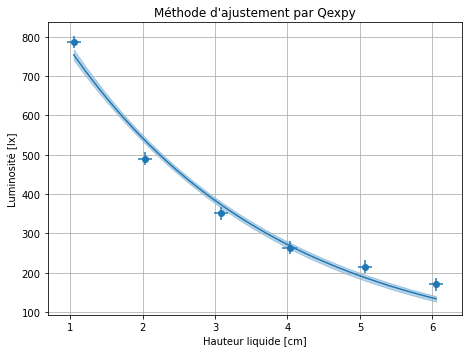

In [53]:
# Fonction du modèle
def f(x, I_O, mu):
  return I_O * qexpy.exp(-mu * x)

qplt.plot(xs, ys)
figure = qplt.get_plot()
figure.title = 'Méthode d\'ajustement par Qexpy'
result = figure.fit(model=f, parguess=[1, 1], parunits=['lx', 'cm^-1'])

I_O = result[0]
mu = result[1]

y_qexpy = {
  'I_0': I_O.value,
  'mu': mu.value,
}

print(I_O)
print(mu)

figure.show()

De même que les deux méthodes précédentes, on a obtenu une valeur proche de $I_0$ égale à $1080$ Lx et de $\mu = 0.35 \ \text{cm}^{-1}$. On obtient aussi une erreur $\Delta I_0 = \pm 30$. Ainsi que $\Delta \mu = \pm 0.01$.

#### Comparaison entre les méthodes d’analyse

On pourra effectuer une comparaison entre les trois méthodes vues précédemment. Pour cela chaque méthode a un `dict` qui contient les informations du meilleurs paramètres $I_0$ et $\mu$ qui optimisant la fonction $I = I_0 \ e^{-\mu \ h}$.

```python
y_analytique: {'I_0': float, 'mu': float},
y_scipy: {'I_0': float, 'mu': float},
y_qexpy: {'I_0': float, 'mu': float}
```

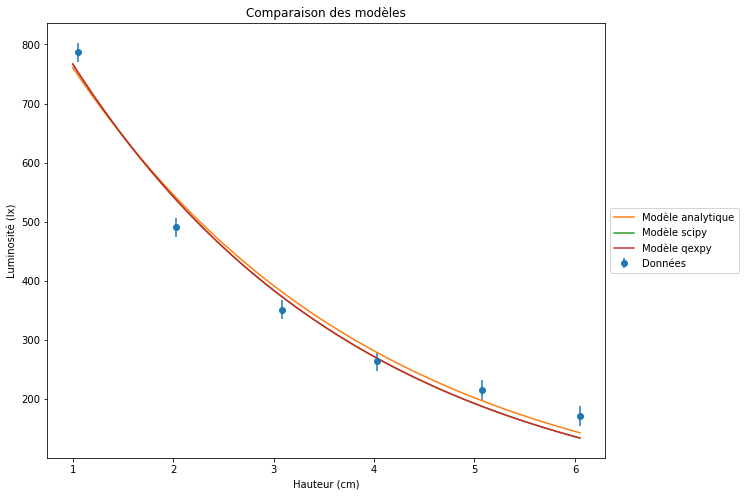

In [36]:
## Comparaison des modèles
x = np.linspace(1, heights[len(heights) - 1], 100)
I_best = lambda I_O, mu, x: I_O * np.exp(-mu * x)

# Methode analytique
I_analytique = I_best(y_analytique['I_0'], y_analytique['mu'], x)

# Methode scipy
I_scipy = I_best(y_scipy['I_0'], y_scipy['mu'], x)

# Methode qexpy
I_qexpy = I_best(y_qexpy['I_0'], y_qexpy['mu'], x)

plt.figure(figsize=(10, 8))
plt.errorbar(heights, luminosites, yerr=luminosite_uncertainty, fmt='o', label='Données')
plt.plot(x, I_analytique, label='Modèle analytique')
plt.plot(x, I_scipy, label='Modèle scipy')
plt.plot(x, I_qexpy, label='Modèle qexpy')
plt.title('Comparaison des modèles')
plt.xlabel('Hauteur (cm)')
plt.ylabel('Luminosité (lx)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


D'après les résultats obtenus, les méthodes numériques avec `scipy` et `qexpy` ont donné des valeurs quasiment identiques, tandis que la méthode analytique a donné des valeurs légèrement différentes.

### Estimation des erreurs sur les paramètres

Pour des modèles linéares et tel comme on a vu dans le cours, on peut calculer les incertitudes sur les paramètres en utilisant $\chi^2$. Dans le cas d'un ajustement linéaire de la forme $y = ax + b$, les erreurs sur les paramètres $a$ et $b$ sont définis par:

$$ B = \sum_{n=1}^{6} \frac{h_i^2}{\sigma_{\Delta \ln(I_i)}^2} \quad \text{et} \quad E = \sum_{n=1}^{6} \frac{1}{\sigma_{\Delta \ln(I_i)}^2} $$

D'où on a:

$$ \Delta a = \frac{\sqrt{ -2 \ \ln(1 - \alpha)}}{\sqrt{B}} = \frac{\sqrt{ -2 \ \ln(1 - \alpha)}}{\sqrt{ \sum_{n=1}^{6} \frac{h_i^2}{\sigma_{\Delta \ln(I_i)}^2} }} $$
$$ \Delta b = \frac{\sqrt{ -2 \ \ln(1 - \alpha)}}{\sqrt{E}} = \frac{\sqrt{ -2 \ \ln(1 - \alpha)}}{\sqrt{ \sum_{n=1}^{6} \frac{1}{\sigma_{\Delta \ln(I_i)}^2} }}  $$

Où le terme $\sqrt{ -2 \ \ln(1 - \alpha)}$ pour une erreur définit à $\alpha = 68.3\%$ vaut $1.52$. Donc il nous suffil donc de calculer les valeurs de $B$ et $E$ pour obtenir les erreurs sur les paramètres.


In [57]:
alpha = 0.683
racine = np.sqrt(-2 * np.log(1 - alpha))

delta_a = racine / np.sqrt(B)
delta_b = racine / np.sqrt(E)

print(result, '\n\n')
print('Erreur sur eC = {:.2f}'.format(delta_a))
print('Erreur sur I_0 = {:.2f} Lx'.format(delta_b))

----------------- Fit Results -------------------
Fit of XY Dataset to custom

Result Parameter List: 
I_O = 1080 +/- 30 [lx],
mu = 0.35 +/- 0.01 [cm^-1]

Correlation Matrix: 
[[1.    0.853]
 [0.853 1.   ]]

chi2/ndof = 22.16/3

--------------- End Fit Results ----------------- 


Erreur sur eC = 0.06
Erreur sur I_0 = 0.15 Lx


La correlation entre les incertitudes sur $\mu = \epsilon C$ et $I_0$, où les deux valeurs sont positivement corrélées, c'est-à-dire que si l'une augmente, l'autre augmente aussi, sans que cela soit nécessairement une relation causale. 

On observe que la vrai valeur de $\epsilon C$ est probablement dans l'intervalle $\epsilon C \pm 0.06$ avec un niveau de confiance de $68.3\%$. Les différences sont plus importantes s'agissant de l'erreur sur $I_0$ sa vrai valeur est dans l'intervalle $I_0 \pm 0.15 $ Lx, avec le même niveau de confiance.

Finalement, on peut utiliser les résultats de de l'ajustement par `qexpy` pour $I_0$, $\sigma_{I_0} = 30$ Lx et pour $\epsilon C$, $\sigma_{\epsilon C} = 0.01$, d'où le coefficient de corrélation obtenue est égale à $0.853$. Si deux valeurs sont entièrement corrélès cette valeurs sera égale à 1, décorrelés si ce coefficient est égale à $0$, donc on pourrait concluire une forte corrélation entre ces deux paramètres.

### Conclusion

Dans ce TP, nous avons étudié la loi Beer-Lambert en faiçant une expérience des mésures des luminosités à partir différents hauteurs d'un liquide choisi (soda) couleur bleu. Ainsi, on a pu ajuster ces mesures à un modèle par plusieurs méthodes: minimisation $\chi^2$ de manière analytique mais aussi numérique avec `scipy`, et finalement un ajustement par `qexpy`. En comparant les tros méthodes utilisées, on a pu constater que les deux meilleures sont celles de `scipy` et `qexpy` car s'approchent mieux aux données mesurées sans arriver a avoir problèmes d'overfiting.

En fin, on a pu montrer la correlation entre les erreurs de $\epsilon C$ et $I_0$ en trouvant une forte corrélation entre ces deux valeurs, ce qui nous donnent une idée de la précision de nos estimations des valeurs trouvées par les trois méthodes utilisées.